In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/kaggle/working"))

# Any results you write to the current directory are saved as output.

In [ ]:
from catboost import CatBoostRegressor, Pool
#data scaling
from sklearn.preprocessing import StandardScaler
#hyperparameter optimization
from sklearn.model_selection import GridSearchCV
#support vector machine model
from sklearn.svm import NuSVR, SVR
#kernel ridge model
from sklearn.kernel_ridge import KernelRidge
#data visualization
import matplotlib.pyplot as plt

In [ ]:
# Loading the training data
train = pd.read_csv("../input/train.csv",nrows = 8000000,dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [ ]:
train_ad_sample_df = train['acoustic_data'].values
train_ttf_sample_df = train['time_to_failure'].values
#visualization and plotting input

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

In [ ]:
#making extra features and adding them to our dataframe

def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [ ]:
#adding to dataframe

train = pd.read_csv('../input/train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [ ]:
m = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, silent=True)

In [ ]:
m.best_score_

In [ ]:
#grid search for best hyperparameters for SVR
#code from siraj raval youtube tutorial
#https://github.com/llSourcell/Kaggle_Earthquake_challenge

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

In [ ]:
#running the SVR model and predicitng outputs

model = SVR(kernel='rbf',gamma=0.02,C=2,tol=0.01)
model.fit(X_train_scaled,y_train)
preds = model.predict(X_train_scaled)



In [ ]:
#shapes for personal understanding
np.shape(X_train_scaled)
np.shape(y_train)

Y_train = y_train
#Y_train = np.reshape(y_train,(4195,1))
np.shape(Y_train.values.flatten())

In [ ]:
Y_train = Y_train.values.flatten().reshape(4195,1)

In [ ]:
#running a lstm model 

from keras.models import Sequential
from keras.layers.core import Dense,Activation,Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [ ]:
#printing values for understanding shapes and inference

X_train_scaled[0:5]
Y_train[0:5]

In [ ]:
#function for lookback in LSTM network

def create(X_train, Y_train, look_back):
    dataX, dataY = [], []
    for i in range(len(X_train)-look_back-1):
        a = X_train[i:(i+look_back), 0:13]
        dataX.append(a)
        dataY.append(Y_train[i + look_back])
    return np.array(dataX), np.array(dataY)

look_back = 10
dataX , dataY = create(X_train_scaled, Y_train , look_back)

print((dataX[0:2]),(dataY[0:2]))

In [40]:
#lstm model

import keras
from keras.layers import Dropout 

model = Sequential()
model.add(LSTM(32, return_sequences = True, input_shape=(look_back, 13)))
model.add(Dropout(0.2))

model.add(LSTM(16, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(8))
model.add(Dropout(0.2))

model.add(Dense(1))

adm = keras.optimizers.Adam(lr = 0.001)
model.compile(loss='mean_squared_error', optimizer=adm)
model.fit(dataX, dataY, epochs=225, batch_size=32, verbose=1)

Epoch 1/225
4184/4184 [==============================] - 11s 3ms/step - loss: 24.6484
Epoch 2/225
4184/4184 [==============================] - 8s 2ms/step - loss: 11.7585
Epoch 3/225
4184/4184 [==============================] - 8s 2ms/step - loss: 9.5977
Epoch 4/225
4184/4184 [==============================] - 8s 2ms/step - loss: 8.3416
Epoch 5/225
4184/4184 [==============================] - 8s 2ms/step - loss: 7.8964
Epoch 6/225
4184/4184 [==============================] - 9s 2ms/step - loss: 7.1860
Epoch 7/225
4184/4184 [==============================] - 8s 2ms/step - loss: 6.7461
Epoch 8/225
4184/4184 [==============================] - 8s 2ms/step - loss: 6.6092
Epoch 9/225
4184/4184 [==============================] - 9s 2ms/step - loss: 6.5068
Epoch 10/225
4184/4184 [==============================] - 9s 2ms/step - loss: 6.2960
Epoch 11/225
4184/4184 [==============================] - 8s 2ms/step - loss: 6.0316
Epoch 12/225
4184/4184 [==============================] - 8s 2ms/step -

4184/4184 [==============================] - 9s 2ms/step - loss: 1.8495
Epoch 98/225
4184/4184 [==============================] - 9s 2ms/step - loss: 1.7522
Epoch 99/225
4184/4184 [==============================] - 9s 2ms/step - loss: 1.7873
Epoch 100/225
4184/4184 [==============================] - 9s 2ms/step - loss: 1.7798
Epoch 101/225
4184/4184 [==============================] - 9s 2ms/step - loss: 1.7434
Epoch 102/225
4184/4184 [==============================] - 9s 2ms/step - loss: 1.7870
Epoch 103/225
4184/4184 [==============================] - 9s 2ms/step - loss: 1.7971
Epoch 104/225
4184/4184 [==============================] - 9s 2ms/step - loss: 1.7097
Epoch 105/225
4184/4184 [==============================] - 9s 2ms/step - loss: 1.7164
Epoch 106/225
4184/4184 [==============================] - 9s 2ms/step - loss: 1.7194
Epoch 107/225
4184/4184 [==============================] - 9s 2ms/step - loss: 1.6513
Epoch 108/225
4184/4184 [==============================] - 9s 2ms/step

4184/4184 [==============================] - 9s 2ms/step - loss: 0.9492
Epoch 193/225
4184/4184 [==============================] - 9s 2ms/step - loss: 1.0255
Epoch 194/225
4184/4184 [==============================] - 9s 2ms/step - loss: 1.0024
Epoch 195/225
4184/4184 [==============================] - 9s 2ms/step - loss: 0.9305
Epoch 196/225
4184/4184 [==============================] - 9s 2ms/step - loss: 0.9931
Epoch 197/225
4184/4184 [==============================] - 9s 2ms/step - loss: 0.9719
Epoch 198/225
4184/4184 [==============================] - 9s 2ms/step - loss: 0.9850
Epoch 199/225
4184/4184 [==============================] - 9s 2ms/step - loss: 0.9824
Epoch 200/225
4184/4184 [==============================] - 9s 2ms/step - loss: 0.9770
Epoch 201/225
4184/4184 [==============================] - 9s 2ms/step - loss: 0.9899
Epoch 202/225
4184/4184 [==============================] - 9s 2ms/step - loss: 0.9800
Epoch 203/225
4184/4184 [==============================] - 9s 2ms/st

In [41]:
preds = model.predict(dataX)


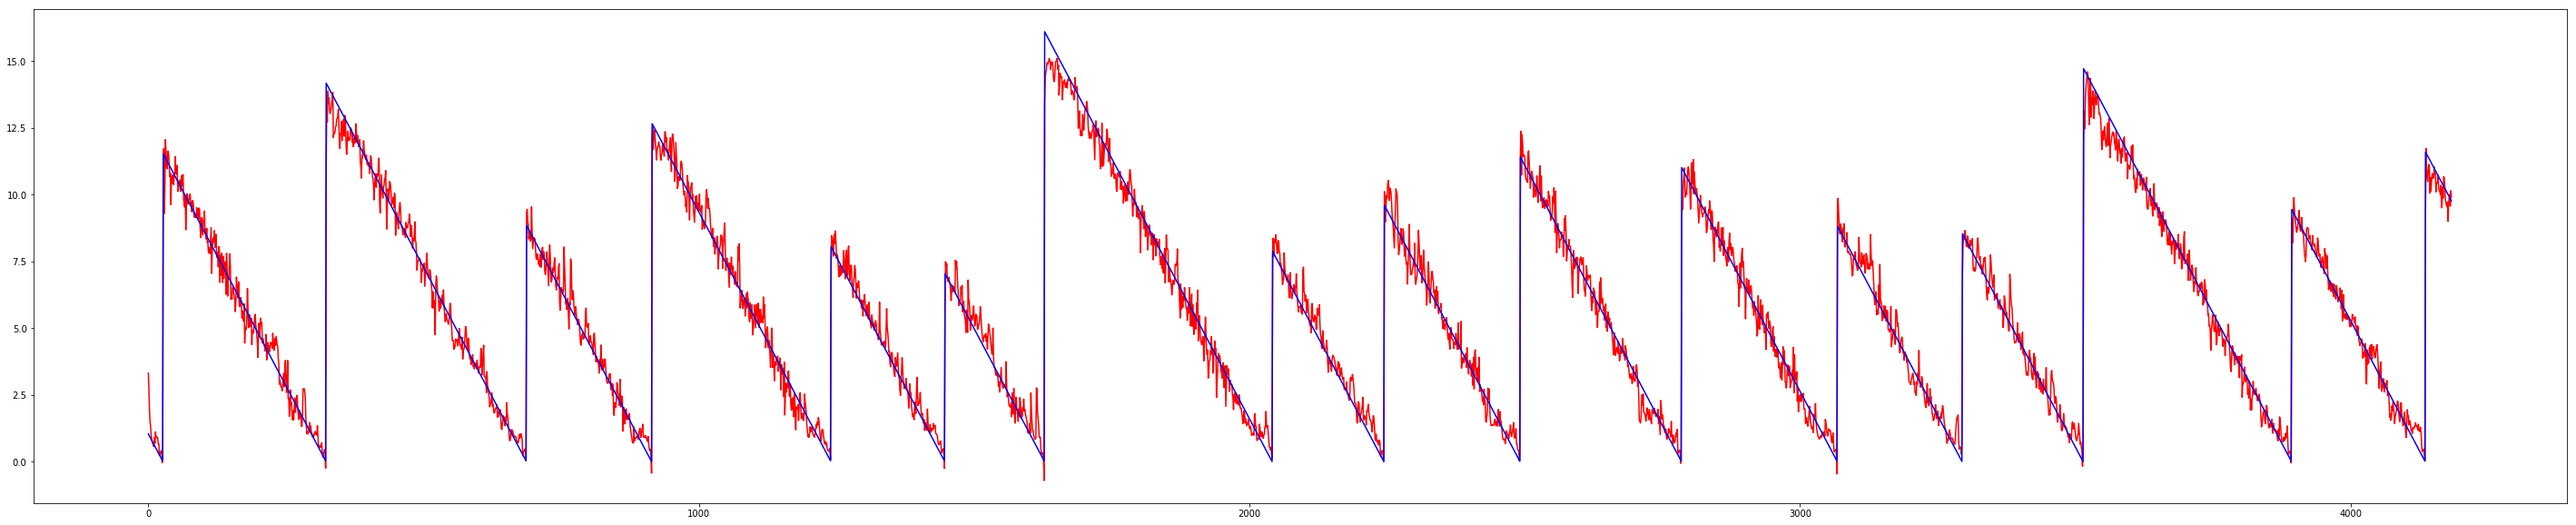

In [42]:
plt.figure(figsize=(50, 10))
plt.plot(preds,color='red',label='Preds')
plt.plot(dataY,color='blue',label='dataY')
plt.show()

In [53]:
def accuracy(DataY,preds):
    count = 0
    for i in range(len(DataY)):
        if( (preds[i] - DataY[i])/DataY[i] < 0.2 ):
            count += 1
    return count/len(DataY)
            
            

In [54]:
accuracy(dataY,preds)

0.8809751434034416

In [ ]:
import glob

test = []
for file in glob.glob("../input/test/*.csv"):
    test.append(file.split('/')[-1].split('.')[0])
test_df = []
for csv in test:
    test_df.append(pd.read_csv(f'../input/test/{csv}.csv'))

In [ ]:
type(test_df[0])
print(type(test_df[0]["acoustic_data"]))

In [ ]:
test = []
for i in test_df:
    temp = gen_features(i["acoustic_data"])
    test.append(temp)



In [ ]:
test = np.reshape(test,(len(test),13))
test_scaled = scaler.transform(test)

In [ ]:
def create_test(X_train, look_back):
    dataX, dataY = [], []
    for i in range(len(X_train)-look_back-1):
        a = X_train[i:(i+look_back), 0:13]
        dataX.append(a)
    
    return dataX
        

In [ ]:
X_test = create_test(test_scaled,look_back)

In [ ]:
X_test = np.reshape(X_test,(len(X_test),look_back,13))
test_preds = model.predict(X_test)

In [ ]:
subs = pd.read_csv('../input/sample_submission.csv')

for i in range(look_back + 1,len(test_preds)):
    subs['time_to_failure'][i] = test_preds[i][0]

In [ ]:
subs.to_csv("SubNoIndex.csv",index=False)

In [ ]:
# import the modules we'll need
from IPython.display import HTML
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a random sample dataframe
df = pd.DataFrame(np.random.randn(50, 4), columns=list('ABCD'))

# create a link to download the dataframe
create_download_link(df)

# ↓ ↓ ↓  Yay, download link! ↓ ↓ ↓ 

In [ ]:
create_download_link(subs,filename="Final.csv")